<a href="https://colab.research.google.com/github/MarioBolanos/Modelado-y-Simulacion/blob/master/7_Complex_Systems/SIR_model_with_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.style
matplotlib.style.use('classic')
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve

# SIR model with control

States: $x = (S, I, R)$, where $S_{(t)}$ is susceptible population, $I_{(t)}$ is infective population and $R_{(t)}$ is recovered population.

$\dot S = S(A-S) - kIS$

$\dot I = kIS - \mu I - \frac{rI}{a + I}$

$\dot R = \frac{rI}{a + I} - \mu R$

Where $A$ is the carrying capacity in the absence of disease, $\mu$ is the natural death rate, $a$ represents a delay in the control action, $k$ and $r$ are the infection and cure rate, respectively.


Model purposed in:
*Qualitative and bifurcation analysis using an SIR model with a saturated treatment function,
Mathematical and Computer Modelling*, Jinliang Wang, Shengqiang Liu, Baowen Zheng, Yasuhiro Takeuchi,
Volume 55, Issues 3–4, 2012, Pages 710-722, ISSN 0895-7177

In [ ]:
def sir_model_control(x, t, A, k, myu, r, a):
    S = x[0]
    I = x[1]
    R = x[2]
    
    S_dot = S*(A - S) - k*I*S
    I_dot = k*I*S - myu*I - ( (r*I)/(a+I) )
    R_dot = ( (r*I)/(a+I) ) - myu*R

    x_dot = [S_dot, I_dot, R_dot]
    return x_dot

# Jacobian of the system

The Jacobian of the SIR model, calculated as:

$J_{ij} = \frac{\partial f_{i}}{\partial x_j}$

In [ ]:
def jacobian_sir(x, t, A, k, myu, r, a):
    S = x[0]
    I = x[1]
    R = x[2]
    
    SS = A - 2*S - k*I
    SI = -k*S
    SR = 0
    IS = k*I
    II = k*S - r/(a + I) + r*I/( (a + I)**2 ) 
    IR = 0
    RS = 0
    RI = r/(a + I) - r*I/( (a + I)**2 ) 
    RR = -myu
    
    jacob = np.array([[SS, SI, SR], [IS, II, IR], [RS, RI, RR]])
    
    return jacob

# Time domain simulation

Solving the ODE system and plotting its time evolution.

In [ ]:
A = 1
k = 0.1
myu = 0.002
r = 0.25
a = 0.2

x0 = [1.1, 8.0, 2.0]
t = np.linspace( 0, 100, 10000 )
solution = odeint( sir_model_control, x0, t, args = (A, k, myu, r, a) ) 

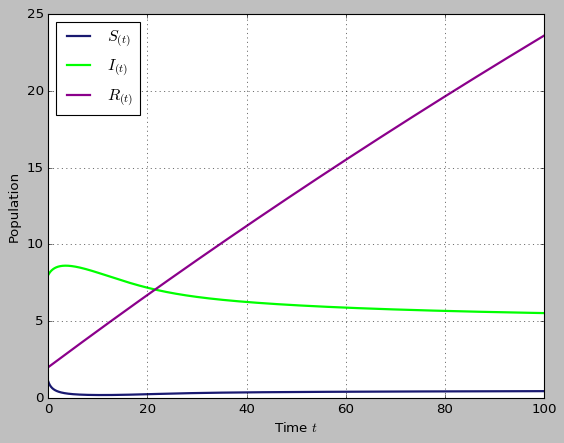

In [ ]:
plt.figure()
plt.plot( t, solution[ : , 0 ], label = '$ S_{(t)} $', color = 'midnightblue', linewidth = 2.0)
plt.plot( t, solution[ : , 1 ], label = '$ I_{(t)} $', color = 'lime', linewidth = 2.0 )
plt.plot( t, solution[ : , 2 ], label = '$ R_{(t)} $', color = 'darkmagenta', linewidth = 2.0 )
plt.legend(loc = 'best')
plt.xlabel('Time $ t $')
plt.ylabel('Population')
plt.grid()
plt.show()

# Find equilibrium points

Given a set of differential equations $\dot x = f_{(x)}$, the equilibrium points $x^*$ of the flux are found by solving:

$\dot x = f_{(x^*)} = 0$

If this problem can't be solved analytically, a numerical method is used (for instance Newton-Raphson method). The obtained numerical solution $x^*$ deppends on the initial condition tested, thus, to find multiple solutions, many initial conditions in the state space are tested.

In [ ]:
def find_equilibria( dynamical_system, x_range, y_range, A, k, myu, r, a ):
# Esta función encuentra muchos equilibrios del sistema. x_range e y_range son el espacio de condiciones iniciales
# diferentes que se van a probar.
    equilibria = list()
    for s_i in x_range:
        for i_i in y_range:

            x0 = [s_i, i_i, 0.0]
            
            x_sol, info_dict, ier, msg = fsolve( dynamical_system, x0, 
                                                args = (0, A, k, myu, r, a), fprime = jacobian_sir, xtol = 1e-7, maxfev = 100000, full_output = True)
            if (ier == 1): # ier es 1 cuando se encuentra solución
                jacob = info_dict['fjac'] # jacobiano evaluado en el punto de equlibrio encontrado
                eigvals = np.linalg.eig( jacob )[0] # valores propios del jacobiano para mirar estabilidad

                if (np.any( np.real(eigvals) >= 0 )): # si la parte real de los valores propios es positiva 
                    equilibria.append( [x_sol, 'unstable']  ) # entonces el equilibrio es inestable
                else: # de lo contrario es estable
                    equilibria.append( [x_sol, 'stable']  )
    #esa lista se transforma en numpy array para fácl manipulación
    equilibria = np.array(equilibria) 

    return equilibria

In [ ]:
#diferentes condiciones iniciales a partir de las cuales se van a buscar equilibrios
x_range = np.linspace(0, 1.5, 21) 
y_range = np.linspace(0, 11, 21)
equilibria = find_equilibria( sir_model_control, x_range, y_range, A, k, myu, r, a )
#equilibria es un array que contiene las coordenadas de cada punto de equilibrio 
#y su correspondiente etiqueta "stable" o "unstable"

In [ ]:
print(equilibria)

[[array([0., 0., 0.]) 'stable']
 [array([0.000e+000, 9.881e-324, 1.067e-321]) 'stable']
 [array([  0.51999995,   4.80000051, 120.00000051]) 'unstable']
 [array([ 7.75670093e-11, -1.25200000e+02,  1.25200000e+02]) 'stable']
 [array([-1.9807595e-16, -1.2520000e+02,  1.2520000e+02]) 'stable']
 [array([-9.3117865e-13, -1.2520000e+02,  1.2520000e+02]) 'stable']
 [array([-2.36279618e-24, -1.25200000e+02,  1.25200000e+02]) 'stable']
 [array([ 2.3757262e-12, -1.2520000e+02,  1.2520000e+02]) 'unstable']
 [array([ 4.01491305e-14, -1.25200000e+02,  1.25200000e+02]) 'unstable']
 [array([ 1.62702713e-14, -1.25200000e+02,  1.25200000e+02]) 'unstable']
 [array([-7.38687797e-21, -1.25200000e+02,  1.25200000e+02]) 'stable']
 [array([ 1.62172521e-14, -1.25200000e+02,  1.25200000e+02]) 'unstable']
 [array([  0.51999999,   4.8000001 , 120.0000001 ]) 'unstable']
 [array([  0.51999999,   4.8000001 , 120.0000001 ]) 'unstable']
 [array([ 9.11393119e-14, -1.25200000e+02,  1.25200000e+02]) 'stable']
 [array([  

# Phase diagram

Where are the equilibria located and how do the trajectories in the state space behave.

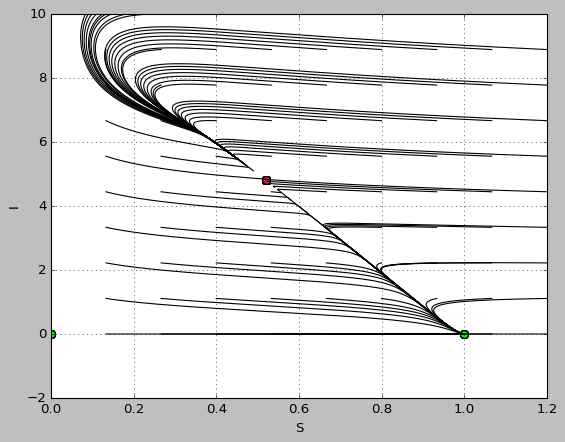

In [ ]:
plt.figure()
#Dibujar líneas de flujo en el espacio de estados:
for s_o in np.linspace(0, 1.2, 10):
    for i_o in np.linspace(0, 10, 10):
        x0 = [s_o, i_o, 0.0] # Probar una gran cantidad de condiciones iniciales y resolver la ODE
        solution = odeint( sir_model_control, x0, t, args = (A, k, myu, r, a) ) 
        plt.plot(solution[ : , 0 ], solution[ : , 1 ], c = 'black')

for each_eq in equilibria: # Dibujar equilibrios en el espacio de estados, rojo = inestable, verde = estable
    if (each_eq[1] == 'unstable'):
        plt.scatter( each_eq[0][0], each_eq[0][1], c = 'crimson', s = 50 )
    else:
        plt.scatter( each_eq[0][0], each_eq[0][1], c = 'lime', s = 50 )
plt.ylim([-2, 10])
plt.xlim([0, 1.2])
plt.xlabel('S')
plt.ylabel('I')
plt.grid()
plt.show()

# Bifurcation diagram

Now check how the location of the equilibria in the state space changes when a parameter of the system is modified. Here, the parameter $k$ is changed from 0.25 to 1.25 and the infectious population level in equilibrium is plotted against this value of $k$. 

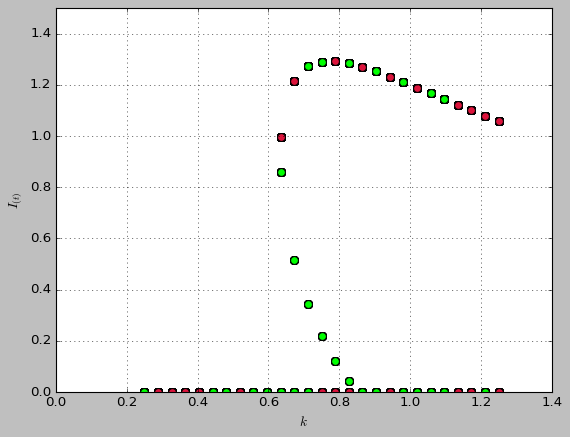

In [ ]:
plt.figure()
for k in np.linspace(0.25, 1.25, 27): 
    A = 2
    myu = 0.2
    r = 1.2
    a = 0.8
    equilibria = find_equilibria( sir_model_control, x_range, y_range, A, k, myu, r, a )
    for each_eq in equilibria:
        if (each_eq[1] == 'unstable'):
            plt.scatter( k, each_eq[0][1], c = 'crimson', s = 50 )
        else:
            plt.scatter( k, each_eq[0][1], c = 'lime', s = 50 )
plt.ylim([0, 1.5])
plt.grid()
plt.ylabel('$I_{(t)}$')
plt.xlabel('$k$')
plt.show()